<a href="https://colab.research.google.com/github/antoniobelotti/HVD/blob/main/1_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Value Detection

Exam project for the information retrieval course, UNIMI 2023, Belotti Antonio 960822.

Multi-label classification task: "predict which of the 20 human value categories are present in a textual argument".



#Setup env

Set this variable to False for a demo run where it's not important to persist results, models and data.

In [ ]:
PERSIST_ON_DRIVE = True

In [ ]:
import pathlib

if PERSIST_ON_DRIVE:
  from google.colab import drive
  drive.mount('/content/gdrive')

  BASE_PATH = pathlib.Path("/content/gdrive/MyDrive/human_value_detection")

  # # create or reuse virtualenv stored on drive
  # !pip3 install virtualenv
  # !virtualenv $BASE_PATH/hvd
  # !source $BASE_PATH/hvd/bin/activate;
else:
  BASE_PATH = pathlib.Path("/content/human_value_detection")

Mounted at /content/gdrive


In [ ]:
!python -m pip install --upgrade
!pip install --no-cache-dir transformers sentencepiece
!pip install accelerate -U
!pip install git+https://github.com/makcedward/nlpaug.git
!pip install torch>=1.6.0 transformers>=4.11.3 sentencepiece
!pip install sacremoses
!pip install -q transformers datasets

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas() # to use progress_apply
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import (
  AutoModelForSequenceClassification,
  AutoModel,
  AutoTokenizer
)

import torch

from sklearn.model_selection import (
  StratifiedKFold,
  cross_validate,
  train_test_split
)
from sklearn.metrics import (
  make_scorer,
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  confusion_matrix,
  classification_report
)

%matplotlib inline

ERROR: You must give at least one requirement to install (see "pip help install")
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 251.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 210.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 128.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 1.2 MB/s eta 0:00:00
  Cloning https://github.com/makcedward/nlpaug.git to /tmp/pip-req-build-cn54wnrl
  Running command git clone --filter=blob:none --quiet https://github.com/makcedward/nlpaug.git /tmp/pip-req-build-cn54wnrl
  Resolved https://github.com/makcedward/nlpaug.git to commit 23800cbb9632c7fc8c4a88d46f9c4ecf68a96299
  Preparing metadata (setup.py) ... done
  Created wheel for nlpaug: filename=nlpaug-1.1.11-py3-none-any.whl size=405888 sha256=

In [ ]:
DATA_PATH = BASE_PATH / "data"
!mkdir -p $DATA_PATH

# Dataset

In [ ]:
from datasets import load_dataset

dataset = load_dataset("webis/Touche23-ValueEval", "main")
dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Argument ID', 'Conclusion', 'Stance', 'Premise', 'Labels'],
        num_rows: 5393
    })
    validation: Dataset({
        features: ['Argument ID', 'Conclusion', 'Stance', 'Premise', 'Labels'],
        num_rows: 1896
    })
    test: Dataset({
        features: ['Argument ID', 'Conclusion', 'Stance', 'Premise', 'Labels'],
        num_rows: 1576
    })
})

## Inspect training set

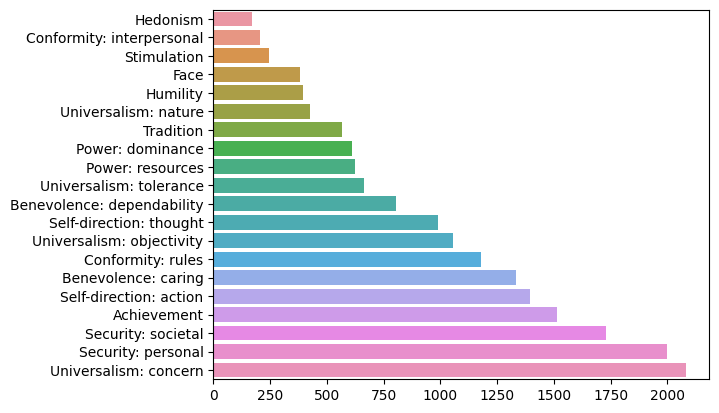

In [ ]:
labels = ["Self-direction: thought", "Self-direction: action", "Stimulation", "Hedonism", "Achievement", "Power: dominance", "Power: resources", "Face", "Security: personal", "Security: societal", "Tradition", "Conformity: rules", "Conformity: interpersonal", "Humility", "Benevolence: caring", "Benevolence: dependability", "Universalism: concern", "Universalism: nature", "Universalism: tolerance", "Universalism: objectivity"]

count = np.array(dataset["train"]["Labels"]).sum(axis=0)

data = {k: v for k, v in sorted(dict(zip(labels,count)).items(), key=lambda item: item[1])}

y = list(data.keys())
x = list(data.values())

b = sns.barplot(x=x, y=y)
b.tick_params(labelsize=10)

plt.show()

What if we group by 'macro-values'?

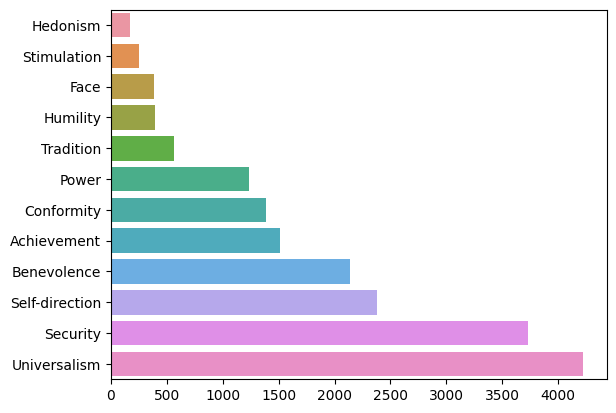

In [ ]:
grouped_data = {}

for old_cat, old_cat_count in zip(labels, count):
  new_cat = old_cat.split(":")[0]
  grouped_data[new_cat] = grouped_data.get(new_cat,0) + old_cat_count

grouped_data = {k: v for k, v in sorted(grouped_data.items(), key=lambda item: item[1])}

y = list(grouped_data.keys())
x = list(grouped_data.values())

b = sns.barplot(x=x, y=y)
b.tick_params(labelsize=10)

plt.show()

## Encode and save

In [ ]:
from datasets import concatenate_datasets
import nlpaug.augmenter.word as naw
import copy
from transformers import AutoTokenizer

MODEL_NAME = "distilbert-base-uncased"
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=False)

In [ ]:
token_lens = pd.DataFrame(dataset["train"])["Premise"].progress_apply(lambda x: len(TOKENIZER.encode(x, max_length=512)))
MAX_TOKENS_LEN = token_lens.max()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'dataset' is not defined

In [ ]:
def encode(sample):
  t = TOKENIZER(sample["Premise"], padding="max_length", truncation=True, max_length=MAX_TOKENS_LEN)
  return {
    "input_ids": t["input_ids"],
    "attention_mask": t["attention_mask"],
    "labels": np.array(sample["Labels"], dtype=float)
  }

encoded_original = dataset.map(encode, batched=True, remove_columns=dataset["train"].column_names)

In [ ]:
encoded_original.save_to_disk(DATA_PATH / MODEL_NAME / "original")

Saving the dataset (0/1 shards):   0%|          | 0/5393 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1896 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1576 [00:00<?, ? examples/s]

# Augmentation

In [ ]:
import copy
from datasets import DatasetDict

## Backtranslation

In [ ]:
augmenter = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-en-de',
    to_model_name='facebook/wmt19-de-en',
    device="cuda"
)

def basktranslate(batch):
  batch["Premise"] = augmenter.augment(batch["Premise"])
  return batch

bt_train = dataset["train"].map(basktranslate, batched=True)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

In [ ]:
bt_aug_ds = DatasetDict({
    "train": bt_train,
    "validation": dataset["validation"],
    "test": dataset["test"]
})
bt_aug_ds = bt_aug_ds.map(encode, batched=True, remove_columns=bt_aug_ds["train"].column_names)

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

In [ ]:
bt_aug_ds.save_to_disk(DATA_PATH / MODEL_NAME / 'backtranslated')

Saving the dataset (0/1 shards):   0%|          | 0/5393 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1896 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1576 [00:00<?, ? examples/s]

## Masking

In [ ]:
import random
import functools

def mask(x):
  tokens = TOKENIZER.tokenize(x["Premise"])
  masked_tokens = tokens.copy()

  for i in range(len(masked_tokens)):
    if random.random() < 0.15:
      masked_tokens[i] = '[MASK]'

  input_ids = TOKENIZER.convert_tokens_to_ids(masked_tokens)
  attention_mask = [1] * len(input_ids)

  return {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "labels": np.array(x["Labels"], dtype=float)
  }

masked_train = dataset["train"].map(mask, batched=False, remove_columns=dataset["train"].column_names)

masked_ds = DatasetDict({
    "train": masked_train,
    "validation": encoded_original["validation"],
    "test": encoded_original["test"]
})

masked_ds.save_to_disk(DATA_PATH / MODEL_NAME / 'masked')

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5393 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1896 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1576 [00:00<?, ? examples/s]

## Summarization

In [ ]:
import transformers
transformers.logging.set_verbosity_error()

In [ ]:
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
import datasets
from torch.utils.data import Dataset as TorchDataset
from tqdm.auto import tqdm

class MyDataset(TorchDataset):
  def __init__(self, data):
    self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, i):
    return self.data[i]

torch_premise_dataset = MyDataset(dataset["train"]["Premise"])

summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=0, framework="pt")

summarized_train_premise = []
for result in tqdm(summarizer(torch_premise_dataset, batch_size=32, min_length=80), total=len(torch_premise_dataset)):
  summarized_train_premise.extend([r["summary_text"] for r in result])

summarized_train_premise[:5]

  0%|          | 0/5393 [00:00<?, ?it/s]

['We should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same. we should ban Human cloning as we should have a ban on cloning of humans. We should also ban cloning of animals as we need to stop the spread of disease. We need to ban Human Cloning of Animals as it is a form of human cloning. We also need to end the practice of cloning of people to create clones.',
 "Fast food is bad for your health and is costly. Fast food should be banned because it is really bad for you, says Dr. Sanjay Gupta. He says fast food is costly and bad for the health of you and your family. It is also a waste of money, he says. It's not healthy to eat fast food all the time and it's expensive to buy it in bulk.",
 'Sometimes economic sanctions are the only thing that will get the corrupt governments to take action. sometimes economic sanctions will be the only way to stop corruption in the first place. Sometimes economic sanctions c

In [ ]:
summarized_ds = copy.deepcopy(dataset)

print("before: " + summarized_ds["train"]["Premise"][0])
summarized_ds["train"] = summarized_ds["train"].remove_columns("Premise")
summarized_ds["train"] = summarized_ds["train"].add_column("Premise", summarized_train_premise)
print("\nafter: " + summarized_ds["train"]["Premise"][0])

before: we should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same.

after: We should ban human cloning as it will only cause huge issues when you have a bunch of the same humans running around all acting the same. we should ban Human cloning as we should have a ban on cloning of humans. We should also ban cloning of animals as we need to stop the spread of disease. We need to ban Human Cloning of Animals as it is a form of human cloning. We also need to end the practice of cloning of people to create clones.


In [ ]:
summarized_ds = summarized_ds.map(encode, batched=True, remove_columns=summarized_ds["train"].column_names)
summarized_ds.save_to_disk(DATA_PATH / MODEL_NAME / 'summarized')

Map:   0%|          | 0/5393 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5393 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1896 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1576 [00:00<?, ? examples/s]